In [1]:
using KalmanFilters
Δt = 0.1
σ_acc_noise = 0.02
σ_meas_noise = 1.0
# Process model
F = [1 Δt Δt^2/2; 0 1 Δt; 0 0 1]
# Process noise covariance
Q = [Δt^2/2; Δt; 1] * [Δt^2/2 Δt 1] * σ_acc_noise^2
# Measurement model
H = [1, 0, 0]'
# Measurement noise covariance
R = σ_meas_noise^2
# Initial state and covariances
x_init = [0.0, 0.0, 0.0]
P_init = [2.5 0.25 0.1; 0.25 2.5 0.2; 0.1 0.2 2.5]
# Take first measurement
measurement = 2.0 + randn()
mu = measurement_update(x_init, P_init, measurement, H, R)
for i = 1:100
    measurement = 2.0 + randn()
    tu = time_update(get_state(mu), get_covariance(mu), F, Q)
    mu = measurement_update(get_state(tu), get_covariance(tu), measurement, H, R)
end

┌ Info: Precompiling KalmanFilters [272a6111-cf0e-4c1b-a056-8d658cb314ee]
└ @ Base loading.jl:1278


In [2]:
F_(x) = x .* [1., 2., 3.0]
x = [0.0, 0.0, 0.0]
P = [2.5 0.25 0.1; 0.25 2.5 0.2; 0.1 0.2 2.5]
tu = time_update(x, P, F_, Q)

KalmanFilters.SPTimeUpdate{Array{Float64,1},Array{Float64,2},KalmanFilters.TransformedSigmaPoints{Float64,Array{Float64,1},Array{Float64,2},WanMerweWeightingParameters}}([0.0, 0.0, 0.0], [2.5000000100000004 0.5000001999999999 0.300002; 0.5000001999999999 10.000004 1.20004; 0.300002 1.20004 22.500400000000003], [0.0 0.0027386127875145315 … 0.0 0.0; 0.0 0.0005477225575029062 … -0.005449770637353 0.0; 0.0 0.00032863353450174375 … -0.0006275493461194363 -0.008185241707953955])

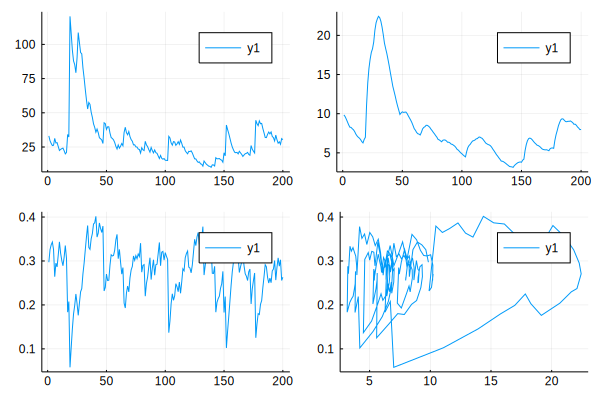

In [3]:
# Augmented state space  [Nt, Bt, wt, vt]
using Distributions
using Plots
## transition function 
function update(x, pars)
    # unpack parameters
    k, winfty,wr,m,r,b = pars
    
    # unpack states
    N = exp(x[1]); B = exp(x[2]); v = x[3]
    
    Nt = (1-m)*N + r*B*exp(v)/(1+b*B)
    Bt = (1-m)*(N*winfty*(1-k)+k*B) + wr*r*B*exp(v)/(1+b*B)
    
    # new states 
    return [log(Nt), log(Bt), 0]
end 


## transition function for simulations 
function update_sim!(x, pars, dR)
    # unpack parameters
    k, winfty,wr,m,r,b = pars
    
    # unpack states
    N = exp(x[1]); B = exp(x[2]); v = x[3]
    
    Nt = (1-m)*N + r*B*exp(v)/(1+b*B)
    Bt = (1-m)*(N*winfty*(1-k)+k*B) + wr*r*B*exp(v)/(1+b*B)

    
    # new states 
    x .= [log(Nt), log(Bt), rand(dR)]
    return [log(Nt), log(Bt),  rand(dR)]
end 


## generate time series
# LH parameters
k = 0.95
winfty = 1.0
wr = 0.0
m = 0.125

# SR paramters
r = 0.5
b_ = 0.1
sigmaR = 1.0
dR = Distributions.Normal(0,sigmaR)

# pars list
pars = (k,winfty,wr,m,r,b_)

# lenth of time series and accumulators
xt = [log(35),log(10.0),0]
T_ = 200
Nt_ = zeros(T_)
Bt_ = zeros(T_)
wt_ = zeros(T_)
obs_Bt = zeros(T_)
obs_wt = zeros(T_)

sigma_obs_B = 1.0
sigma_obs_w = 0.01

for t in 1:T_
    xt = update_sim!(xt, pars, dR)
    Nt_[t] = exp(xt[1])
    Bt_[t] = exp(xt[2])
    wt_[t] = exp(xt[2] - xt[1])
    
    obs_Bt[t] = xt[2] + rand(Distributions.Normal(0,sigma_obs_B))
    obs_wt[t] = xt[2] - xt[1]+ rand(Distributions.Normal(0,sigma_obs_w))
end 

    
yt = broadcast(i -> [obs_Bt[i], obs_wt[i]], 1:T_)
    

p1 = Plots.plot(Nt_)
p2 = Plots.plot(Bt_)
#Plots.scatter!(exp.(obs_Bt))
p3 = Plots.plot(wt_)
#Plots.scatter!(exp.(obs_wt))
p4 = Plots.plot(Bt_,wt_)
plot(p1,p2,p3,p4)

In [4]:
using KalmanFilters
pars = (k,winfty,wr,m,r,b_)
#### initalize filters ####
# prior distribution 
x0 = [3.0,3.0,0.0]
P0 = [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.1]

H = [0.0 1.0 0.0 ; -1.0 1.0 0.0]
Sigma_N = [0.01 0.0 0.0 ; 
           0.0 0.01 0.0 ;
           0.0 0.0 sigmaR]

Sigma_O = [sigma_obs_B 0.0;
           0.0 sigma_obs_w]

f =x -> update(x, pars)

# step 1 to init KalmanFilter object
uKF = KalmanFilters.time_update(x0,P0, f,  Sigma_N)

uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[1],H,Sigma_O)

KalmanFilters.KFMeasurementUpdate{Array{Float64,1},Array{Float64,2},Array{Float64,1},Array{Float64,2},Array{Float64,2}}([3.473341860572918, 2.3179103537003165, 0.0], [0.0500473240918582 0.04557338149630767 0.0; 0.04557338149630767 0.05050430959769191 0.0; 0.0 0.0 1.0], [-0.8910372091008152, -1.030854687134464], [1.1005451246225262 0.09118537524353186; 0.09118537524353186 0.17558585126630774], [0.04557338149630767 -0.4473942595550524; 0.05050430959769191 0.4930928101384227; 0.0 0.0])

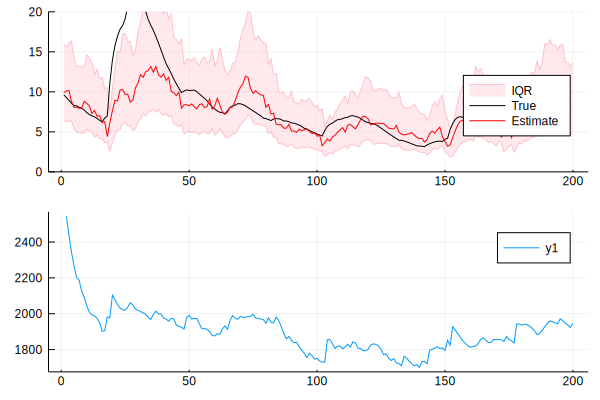

In [5]:
using LinearAlgebra

x = get_state(uKF)
P = get_covariance(uKF)

### accumulators ###

# kalman filter
B_hat = zeros(T_)
N_hat = zeros(T_)
B_lower, B_upper = zeros(T_),zeros(T_)
N_lower, N_upper = zeros(T_),zeros(T_)

N_hat[1] = x[1]
B_hat[1] = x[2]

N_lower[1], N_upper[1] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
B_lower[1], B_upper[1] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])

H_t = zeros(T_)

frequency = 1
#### iterate ove time series ####
for t in 2:T_
    # update Kalman Filter
    uKF = KalmanFilters.time_update(get_state(uKF),get_covariance(uKF), x ->update(x, pars),  Sigma_N)
    
    if mod(t,frequency) == 0
        uKF = KalmanFilters.measurement_update(get_state(uKF),get_covariance(uKF),yt[t],H,Sigma_O)
    end
        
    x = get_state(uKF)
    P = get_covariance(uKF)
    N_hat[t] = x[1]
    B_hat[t] = x[2]

    B_lower[t], B_upper[t] = x[2] - 2*sqrt(P[2,2]), x[2] + 2*sqrt(P[2,2])
    N_lower[t], N_upper[t] = x[1] - 2*sqrt(P[1,1]), x[1] + 2*sqrt(P[1,1])
    
    H_t[t] = LinearAlgebra.det(P[1:2,1:2])
end 

p1 = Plots.plot(exp.(B_lower), fillrange = exp.(B_upper), 
    fillalpha = 0.35, color = "pink", label = "IQR")

Plots.plot!(p1, exp.(B_upper), color = "pink", label = "")

Plots.plot!(p1,Bt_[2:end], color = "black", label = "True")

Plots.plot!(p1,exp.(B_hat)[2:end], color = "red", label = "Estimate", ylim = (0,20), legend = :bottomright)

p2 = Plots.plot(1 ./H_t)


plot(p1,p2, layout = (2,1))

## Think about a three way trade off between Harvest, Stability and Management costs 

The goal of this will be to develop some intuition about the bioeconomic problem by first aproaching it using control systems theory. The idea here is to analyze a the equilibrium and stability of the system when a simple control rule is applied. This differns from a bioeconomic optimizaiton approach becasue it does not find optimal policies rather it tests the value of simple control rules. 


### Harvest limit to fishing effort

$B - H = exp(-F)B$

$H = (1-exp(-F))B $

$F = -log\left(\frac{ B- H}{B} \right)$

$B =  H /(1 -exp(-F))$

Policy is to target set H such that $F = F_{MSY}$ to do this we use the estimator $H = (1-e^{-F_{MSY}})\hat{B}$

The acutal fishing level is $F_t = min\left\{-log\left(\frac{ B- H_t}{B} \right), F_{max}  \right\}$

An alterantive policy target is the $p^* - \sigma$ rule where the probaiblity of $F_t >F_{MSY}$ is set to a desired probability say $40\%$.



$P\left(-log\left(\frac{ B- H}{B}\right)  < F_{MSY} | \hat{B}, \sigma_{\hat{B}}\right) = \Phi\left( \frac{H}{1 -exp(-F_{MSY})}| \hat{B}, \sigma_{\hat{B}} \right) = p^*$

$H_t = \Phi^{-1}\left(p^*| \hat{B}, \sigma_{\hat{B}}\right)(1-exp(-F_{MSY}))$

### parameters

-$F_{target}$

-$p^*$

-$\sigma_{obs,B_t}$

-$\sigma_{obs,w_t}$

-$\omega_{obs}$


### Monitoring costs

Monitoring costs are a linear function of the precision of the observation. 

To correct for the fact that our observation varinace $\sigma_{B}$ is on the log scale we need to think about this interms of the precision of a low -normal variable

$\frac{1}{(e^{\sigma^2} - 1)e^{2B+\sigma^2}}$

I am going to ignore the effect of the biomass on the variance / assume that it is sufficent to use the average biomass 

$C(\sigma) = C_0 + \frac{C_v}{(e^{\sigma^2} - 1)e^{\sigma^2}}$


$Var(\hat{B})=\frac{\bar{B}}{E^2}= (e^{\sigma^2} - 1)e^{2\bar{B}+\sigma^2}$

$E= \sqrt{\frac{\bar{B}}{(e^{\sigma^2} - 1)e^{2\bar{B}+\sigma^2}}}$

$C(\sigma) = c_0 + c_v \sqrt{\frac{1}{(e^{\sigma^2} - 1)e^{\sigma^2}}}$

## Test simulations with HCR

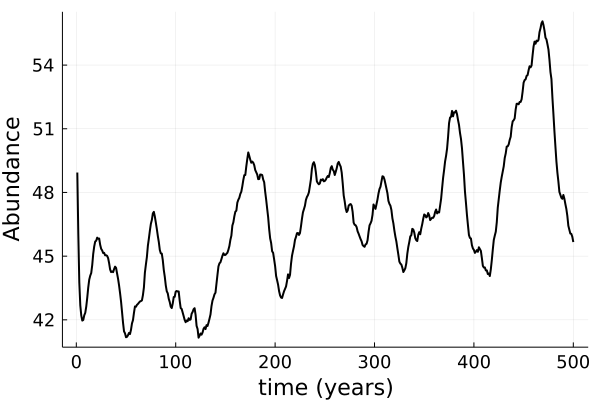

In [665]:
include("BiomassDynamics.jl")
using Plots
#### set parameters ####
# LH parameters
k = 0.85
winfty = 1.0
wr = 0.0
m = 0.15

# SR paramters
r = 1.00
b_ = 0.02
sigmaR = 0.05
dR = Distributions.Normal(0,sigmaR)

# pars list
pars = (k,winfty,wr,m,r,b_,sigmaR, 0.25)

sigma_obs_B = 0.25
sigma_obs_w = 0.025

#### initalize filters ####
#observation functions
H = [0.0 1.0 0.0 ; -1.0 1.0 0.0]
Sigma_N = [0.01 0.0 0.0 ; 
           0.0 0.01 0.0 ;
           0.0 0.0 sigmaR]

Sigma_O = [sigma_obs_B 0.0;
           0.0 sigma_obs_w]

#### initialize state ####
Fmsy = 0.8*BiomassDynamics.Fmsy(pars)[2]
xt = log.(BiomassDynamics.equib(Fmsy, pars))
xt = vcat(xt,[0.0])#[log(100.0),log(70.0), 0.0]
xhat = xt
P0 = [0.5 0.0 0.0; 0.0 0.5 0.0; 0.0 0.0 sigmaR]

state = BiomassDynamics.state(xt, 0.0,0.0, xhat, P0)

#### initialize accuulators ####

T = 500
Tshock = 501
sigma_increase = 5.0
decline = 0.75

Ht = zeros(T)
Bt = zeros(T)
Ft = zeros(T)
B_hat = zeros(T)
B_lower = zeros(T)
B_upper = zeros(T)
#### harvest parameters ####
Ftarget = Fmsy
pstar = 0.8
HCR = state -> BiomassDynamics.p_star_sigma(state,Ftarget,pstar)

omega = 1

for i in 1:T
    BiomassDynamics.time_step!(state,pars,HCR)
    if i ==Tshock
        state = BiomassDynamics.state(state.xt .+log(decline), state.Ht,state.Ft, state.xhat, sigma_increase*state.Sigma)#)P0_shock)
    end

    if mod(i,omega) == 0
        BiomassDynamics.observation!(state,pars,Sigma_O)
        end 

    Ht[i] = state.Ht
    Bt[i] = state.xt[2]
    Ft[i] = state.Ft
    B_hat[i] = state.xhat[2]
    B_lower[i], B_upper[i] = state.xhat[2] - 2*sqrt(state.Sigma[2,2]), state.xhat[2] + 2*sqrt(state.Sigma[2,2])
end 

p1 = Plots.plot(exp.(Bt), ylab = "Bt")

Plots.plot!(p1,exp.(B_lower), fillrange = exp.(B_upper), 
    fillalpha = 0.35, color = "pink", label = "IQR")
Plots.plot!(p1, exp.(B_upper), color = "pink", label = "")

Plots.plot!(p1,exp.(B_hat)[2:end], color = "red", label = "Estimate", legend = :none)



p2 = Plots.plot( Ht, ylab = "Ht")

p3 = Plots.plot(Ft, ylab = "Ft")

plot(p1,p2,p3)

Plots.plot(exp.(Bt), xlab = "time (years)", 
                label = "", ylab = "Abundance", 
                color = "black", width = 2,
           yguidefontsize = 15, xguidefontsize = 15,
            ytickfontsize = 12,xtickfontsize = 12)

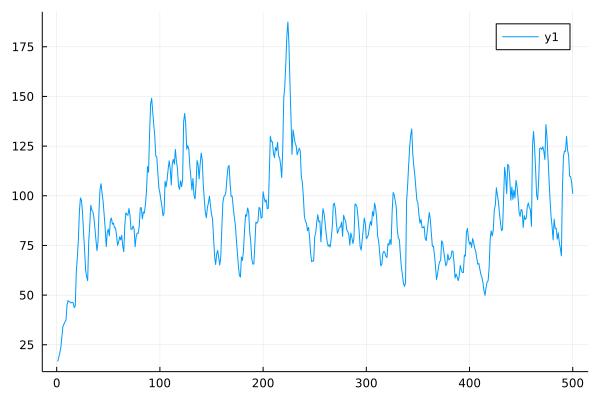

In [669]:
include("BiomassDynamics.jl")
#### set parameters ####
# LH parameters
k = 0.75
winfty = 1.0
wr = 0.0
m = 0.25

# SR paramters
r = 2.00
b_ = 0.02
sigmaR = 0.5
dR = Distributions.Normal(0,sigmaR)

# pars list
pars = (k,winfty,wr,m,r,b_,sigmaR, 0.25)


### Observation parameters #####
sigma_obs_B = 0.25
sigma_obs_w = 0.05

omega = 1
Sigma_O = [sigma_obs_B 0.0;
           0.0 sigma_obs_w]


#### Harvest Control Rule ####
Ftarget = 0.05
pstar = 0.8
HCR = x -> BiomassDynamics.p_star_sigma(x,Ftarget,pstar)


#### Number of time steps ####
T = 500

#### Initialize State ####
N0 = 40.0
B0 = 20.0
xt = [log(N0),log(B0), 0.0]
xhat = [log(N0),log(B0), 0.0]
P0 = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 sigmaR]

state0 = BiomassDynamics.state(xt, 0.0,0.0, xhat, P0)



Bt, Ht, Ft, Sigma_Bt = BiomassDynamics.simulation(state0,pars,omega,Sigma_O,HCR,T)



In [50]:

function mean_var_Ht(state,sigma_obs_B, sigma_obs_w, omega, pstar, Ftarget, pars)
    Sigma_O = [sigma_obs_B 0.0;
           0.0 sigma_obs_w]
    HCR = x -> BiomassDynamics.p_star_sigma(x,Ftarget,pstar)
    N0 = 40.0
    B0 = 20.0
    xt = [log(N0),log(B0), 0.0]
    xhat = [log(N0),log(B0), 0.0]
    P0 = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 sigmaR]

    state0 = BiomassDynamics.state(xt, 0.0,0.0, xhat, P0)
    return BiomassDynamics.mean_variance_Ht(state,pars,omega,Sigma_O,HCR,100000)
end 



mean_var_Ht (generic function with 1 method)

In [ ]:
#### set parameters ####
# LH parameters
k = 0.85
winfty = 1.0
wr = 0.0
m = 0.15

# SR paramters
r = 1.0
b_ = 0.05
sigmaR = 0.1
dR = Distributions.Normal(0,sigmaR)

# pars list
pars = (k,winfty,wr,m,r,b_,sigmaR, 0.25)

Ftarget = 0.075
pstar = 0.3

meanH =  zeros(8,length(0.05:0.05:1.0))
sdH =  zeros(8,length(0.05:0.05:1.0))
#### Initialize State ####
N0 = 40.0
B0 = 20.0
xt = [log(N0),log(B0), 0.0]
xhat = [log(N0),log(B0), 0.0]
P0 = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 sigmaR]

state = BiomassDynamics.state(xt, 0.0,0.0, xhat, P0)

i = 0
for omega in 1:8
    println(omega)
    i += 1
    j = 0
    for sigma_obs_B in 0.05:0.05:1.0
        j += 1
        meanHt,sdHt = mean_var_Ht(state,sigma_obs_B, sigma_obs_w, omega, pstar, Ftarget, pars)
        meanH[i,j] = meanHt
        sdH[i,j] = sdHt
    end
end 


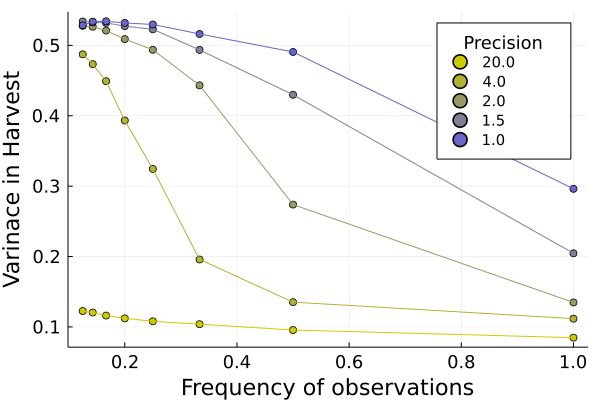

In [610]:
using Plots
default(size = (600, 400))
p = Plots.scatter(1 ./collect(1:8), sdH[:,1], color = RGB(0.8,0.8,0.0), label = "20.0")
Plots.plot!(1 ./collect(1:8), sdH[:,1], color = RGB(0.8,0.8,0.0), label = "")
Plots.scatter!(1 ./collect(1:8), sdH[:,5], color = RGB(0.7,0.7,0.2), label = "4.0")
Plots.plot!(1 ./collect(1:8), sdH[:,5], color = RGB(0.7,0.7,0.2), label = "")
Plots.scatter!(1 ./collect(1:8), sdH[:,10], color = RGB(0.6,0.6,0.4), label = "2.0")
Plots.plot!(1 ./collect(1:8), sdH[:,10], color = RGB(0.6,0.6,0.4), label = "")
Plots.scatter!(1 ./collect(1:8), sdH[:,15], color = RGB(0.5,0.5,0.6), label = "1.5")
Plots.plot!(1 ./collect(1:8), sdH[:,15], color = RGB(0.5,0.5,0.6), label = "")
Plots.scatter!(1 ./collect(1:8), sdH[:,20], color = RGB(0.4,0.4,0.8), label = "1.0")
Plots.plot!(1 ./collect(1:8), sdH[:,20], color = RGB(0.4,0.4,0.8), label = "",
            xlab = "Frequency of observations", ylab = "Varinace in Harvest",legend_title = "Precision",
            legendfontsize=10, yguidefontsize = 15, xguidefontsize = 15,
            ytickfontsize = 12,xtickfontsize = 12, legendtitlefontsize = 12)
 


# Resiliance 

In [667]:
include("BiomassDynamics.jl")
using Plots
#### set parameters ####
# LH parameters
k = 0.8
winfty = 1.0
wr = 0.0
m = 0.2

# SR paramters
r = 2.0
b_ = 0.02
sigmaR = 0.1
dR = Distributions.Normal(0,sigmaR)

# pars list
pars = (k,winfty,wr,m,r,b_,sigmaR, 0.25)


sigma_obs_B = 0.55
sigma_obs_w = 0.1*sigma_obs_B 
sigma_increase = 2.0
decline = 0.5

function recovery(sigma_obs_B ,pars, decline, sigma_increase;T = 400, Tshock = 100)
    #### initalize filters ####
    #observation functions
    H = [0.0 1.0 0.0 ; -1.0 1.0 0.0]
    Sigma_N = [0.01 0.0 0.0 ; 
               0.0 0.01 0.0 ;
               0.0 0.0 sigmaR]

    Sigma_O = [sigma_obs_B 0.0;
               0.0 sigma_obs_w]

    #### initialize state ####
    Fmsy = BiomassDynamics.Fmsy(pars)[2]
    xt = log.(BiomassDynamics.equib(Fmsy, pars))
    xt = vcat(xt,[0.0])#[log(100.0),log(70.0), 0.0]
    xhat = xt
    P0 = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 sigmaR]
    state = BiomassDynamics.state(xt, 0.0,0.0, xhat, P0)


    #### initialize accuulators ####

    Ht = zeros(T)
    Bt = zeros(T)
    Ft = zeros(T)
    B_hat = zeros(T)
    B_lower = zeros(T)
    B_upper = zeros(T)
    #### harvest parameters ####
    Ftarget = Fmsy
    pstar = 0.4
    HCR = state -> BiomassDynamics.p_star_sigma(state,Ftarget,pstar)

    omega = 1

    for i in 1:T
        BiomassDynamics.time_step!(state,pars,HCR)
        if i ==Tshock
            state = BiomassDynamics.state(state.xt .+log(decline), state.Ht,state.Ft, state.xhat, sigma_increase*state.Sigma)#)P0_shock)
        end

        if mod(i,omega) == 0
            BiomassDynamics.observation!(state,pars,Sigma_O)
        end 
        Ht[i] = state.Ht
        Bt[i] = state.xt[2]
        Ft[i] = state.Ft
        B_hat[i] = state.xhat[2]
        B_lower[i], B_upper[i] = state.xhat[2] - 2*sqrt(state.Sigma[2,2]), state.xhat[2] + 2*sqrt(state.Sigma[2,2])
    end 
    
    # calcualte time to recovery 
    Bt = exp.(Bt)
    Tls = 1:T
    Tls = Tls[(Tshock+3):end]
    Btrecovered = sum(Bt[1:(Tshock)])/Tshock
    Bt_recovery = Bt[(Tshock+3):end]
    Btmin = Bt_recovery[argmin(Bt_recovery)]
    B50 = Btrecovered - 0.5*(Btrecovered - Btmin)
    B90 = Btrecovered - 0.1*(Btrecovered - Btmin)
    
    # if recovery does not occur set to 1000
    if sum(Bt_recovery .> B50) == 0
        T50 = 1000 + Tshock
    else
        T50 = Tls[Bt_recovery .> B50][argmin(Tls[Bt_recovery .> B50])]
    end
    
    
    if sum(Bt_recovery .> B90) == 0
        T90 = 1000 + Tshock
    else
        T90 = Tls[Bt_recovery .> B90][argmin(Tls[Bt_recovery .> B90])]
    end
    
    
    return T50-Tshock, T90-Tshock
end 


recovery (generic function with 1 method)

In [668]:
obs_pres = 1.0:10.0
sigma_obs_Bls = 1 ./obs_pres
Ntrials = 500
T50_anticipate = zeros(Ntrials,length(sigma_obs_Bls))
T50_suprise = zeros(Ntrials,length(sigma_obs_Bls))
i = 0
for sigma_obs_B in sigma_obs_Bls
    i+=1
    acc50 = 0
    acc90 = 0
    print(i, " ")
    j = 0
    for t in 1:Ntrials 
        j += 1
        sigma_obs_w = 0.1*sigma_obs_B 
        sigma_increase = 4.0
        decline = 0.6
        T50, T90 = recovery(sigma_obs_B , pars, decline, sigma_increase)
        T50_anticipate[j,i] = T50
        T50, T90 = recovery(sigma_obs_B , pars, decline, 1.0)
        T50_suprise[j,i] = T50
    end
    
end 

using DelimitedFiles
writedlm( "Recovery_anticipated.csv",  T50_anticipate, ',')
writedlm( "Recovery_suprise.csv",  T50_suprise, ',')


1 2 3 4 5 6 7 8 

LoadError: [91mInterruptException:[39m

1
2
3
4
5
6
7
8


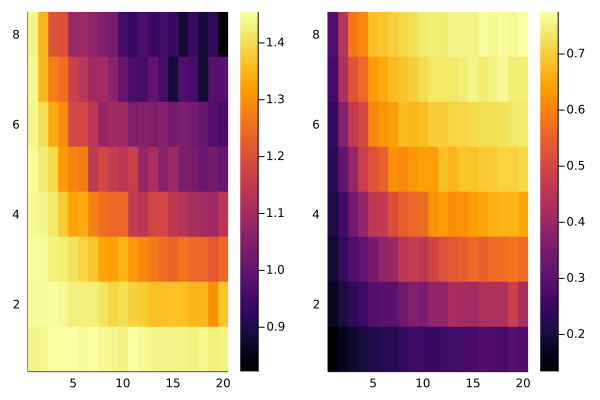

In [809]:
# LH parameters
k = 0.9
winfty = 1.0
wr = 0.0
m = 0.1

# SR paramters
r = 1.0
b_ = 0.05
sigmaR = 0.1
dR = Distributions.Normal(0,sigmaR)

# pars list
pars = (k,winfty,wr,m,r,b_,sigmaR, 0.25)

Ftarget = 0.1
pstar = 0.2

meanH =  zeros(8,length(0.05:0.05:1.0))
sdH =  zeros(8,length(0.05:0.05:1.0))
#### Initialize State ####
N0 = 40.0
B0 = 20.0
xt = [log(N0),log(B0), 0.0]
xhat = [log(N0),log(B0), 0.0]
P0 = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 sigmaR]

state = BiomassDynamics.state(xt, 0.0,0.0, xhat, P0)

sigma_obs_w = 0.005

i = 0
for omega in 1:8
    println(omega)
    i += 1
    j = 0
    for sigma_obs_B in 0.05:0.05:1.0
        j += 1
        meanHt,sdHt = mean_var_Ht(state,sigma_obs_B, sigma_obs_w, omega, pstar, Ftarget, pars)
        meanH[i,j] = meanHt
        sdH[i,j] = sdHt
    end
end 

p1 = Plots.heatmap(meanH)
p2 = Plots.heatmap(sdH)

plot(p1,p2)

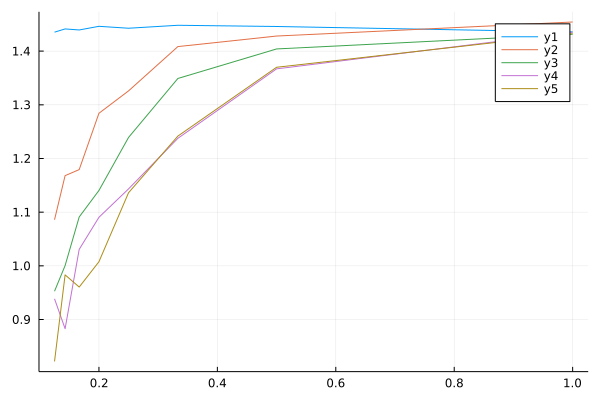

In [813]:
Plots.plot(1 ./collect(1:8), meanH[:,1])
Plots.plot!(1 ./collect(1:8), meanH[:,5])
Plots.plot!(1 ./collect(1:8), meanH[:,10])
Plots.plot!(1 ./collect(1:8), meanH[:,15])
Plots.plot!(1 ./collect(1:8), meanH[:,20])

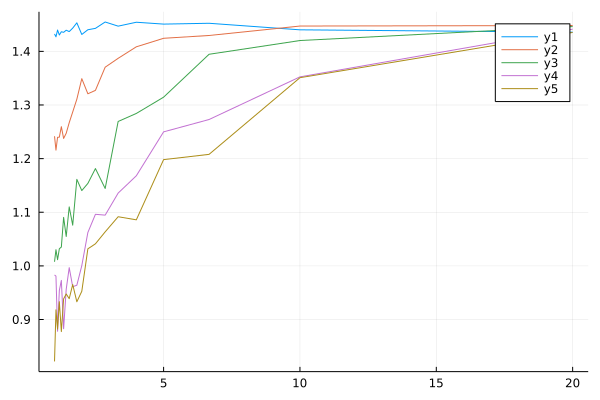

In [814]:
Plots.plot(1 ./collect(0.05:0.05:1.0), meanH[1,:])
Plots.plot!(1 ./collect(0.05:0.05:1.0), meanH[3,:])
Plots.plot!(1 ./collect(0.05:0.05:1.0), meanH[5,:])
Plots.plot!(1 ./collect(0.05:0.05:1.0), meanH[7,:])
Plots.plot!(1 ./collect(0.05:0.05:1.0), meanH[8,:])

In [777]:
function recovery_series(sigma_obs_B ,pars, decline, sigma_increase,omega;T = 400, Tshock = 100)
    #### initalize filters ####
    #observation functions
    H = [0.0 1.0 0.0 ; -1.0 1.0 0.0]
    Sigma_N = [0.01 0.0 0.0 ; 
               0.0 0.01 0.0 ;
               0.0 0.0 sigmaR]

    Sigma_O = [sigma_obs_B 0.0;
               0.0 sigma_obs_w]

    #### initialize state ####
    Fmsy = BiomassDynamics.Fmsy(pars)[2]
    xt = log.(BiomassDynamics.equib(Fmsy, pars))
    xt = vcat(xt,[0.0])#[log(100.0),log(70.0), 0.0]
    xhat = xt
    P0 = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 sigmaR]
    state = BiomassDynamics.state(xt, 0.0,0.0, xhat, P0)


    #### initialize accuulators ####

    Ht = zeros(T)
    Bt = zeros(T)
    Ft = zeros(T)
    B_hat = zeros(T)
    B_lower = zeros(T)
    B_upper = zeros(T)
    #### harvest parameters ####
    Ftarget = Fmsy
    pstar = 0.3
    HCR = state -> BiomassDynamics.p_star_sigma(state,Ftarget,pstar)

    

    for i in 1:T
        BiomassDynamics.time_step!(state,pars,HCR)
        if i ==Tshock
            state = BiomassDynamics.state(state.xt .+log(decline), state.Ht,state.Ft, state.xhat, sigma_increase*state.Sigma)#)P0_shock)
        end

        if mod(i,omega) == 0
            BiomassDynamics.observation!(state,pars,Sigma_O)
        end 
        Ht[i] = state.Ht
        Bt[i] = state.xt[2]
        Ft[i] = state.Ft
        B_hat[i] = state.xhat[2]
        B_lower[i], B_upper[i] = state.xhat[2] - 2*sqrt(state.Sigma[2,2]), state.xhat[2] + 2*sqrt(state.Sigma[2,2])
    end 
    return Ht,Ft,Bt,B_hat,B_lower,B_upper
end 

recovery_series (generic function with 2 methods)

In [1014]:
# LH parameters
k = 0.8
winfty = 1.0
wr = 0.0
m = 0.2

# SR paramters
r = 2.0
b_ = 0.05
sigmaR = 0.1
dR = Distributions.Normal(0,sigmaR)

# pars list
pars = (k,winfty,wr,m,r,b_,sigmaR, 0.25)
Ht,Ft,Bt,Bhat,B_lower,B_upper = recovery_series(0.05 ,pars, 2.0, 1.0,1;T = 400, Tshock = 99)
print("")

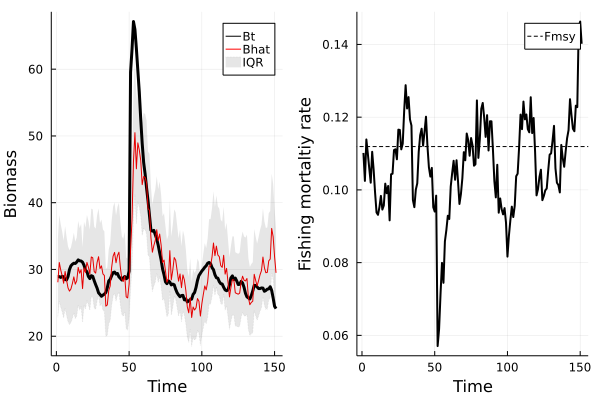

In [1015]:
Tshock = 99

p1 = Plots.plot(exp.(Bt[(Tshock-50):(Tshock+100)]), color = "black", width = 3, label = "Bt", ylabel = "Biomass")  
Plots.plot!(exp.(Bhat[(Tshock-50):(Tshock+100)]), color = "red", label = "Bhat", xlabel = "Time")
Plots.plot!(exp.(B_lower[(Tshock-50):(Tshock+100)]),
fillrange = exp.(B_upper[(Tshock-50):(Tshock+100)]),
color = "black", style =:dot, alpha = 0.1, label = "IQR")





p2 = Plots.plot(Ft[(Tshock-50):(Tshock+100)], color = "black", width = 2, ylabel = "Fishing mortaltiy rate", label ="")
Plots.hline!([BiomassDynamics.Fmsy(pars)[2]], color = "black", style = :dash, label = "Fmsy", xlabel = "Time")
#Plots.plot!((Bhat[(Tshock-25):(Tshock+50)] .-Bt[(Tshock-25):(Tshock+50)]).^2)
plot(p1,p2,layout = (1,2))

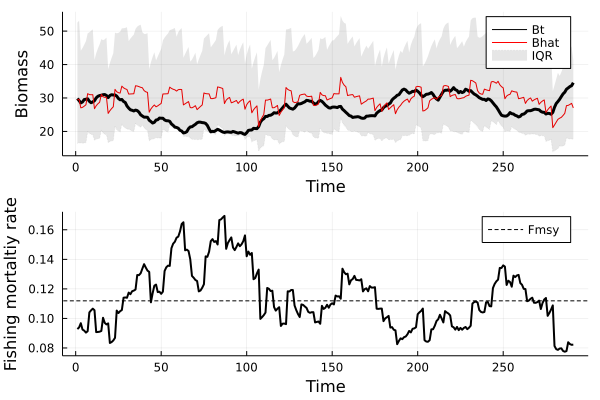

In [1025]:
Ht,Ft,Bt,Bhat,B_lower,B_upper = recovery_series(0.25 ,pars, 0.5, 2.0,4;T = 300, Tshock = 301)
p1 = Plots.plot(exp.(Bt[10:end]), color = "black", width = 3, label = "Bt", ylabel = "Biomass")  
Plots.plot!(exp.(Bhat[10:end]), color = "red", label = "Bhat", xlabel = "Time")
Plots.plot!(exp.(B_lower[10:end]),
fillrange = exp.(B_upper[10:end]),
color = "black", style =:dot, alpha = 0.1, label = "IQR")






p2 = Plots.plot(Ft[10:end], color = "black", width = 2, ylabel = "Fishing mortaltiy rate", label ="")
Plots.hline!([BiomassDynamics.Fmsy(pars)[2]], color = "black", style = :dash, label = "Fmsy", xlabel = "Time")
#Plots.plot!((Bhat[(Tshock-25):(Tshock+50)] .-Bt[(Tshock-25):(Tshock+50)]).^2)
plot(p1,p2,layout = (2,1))

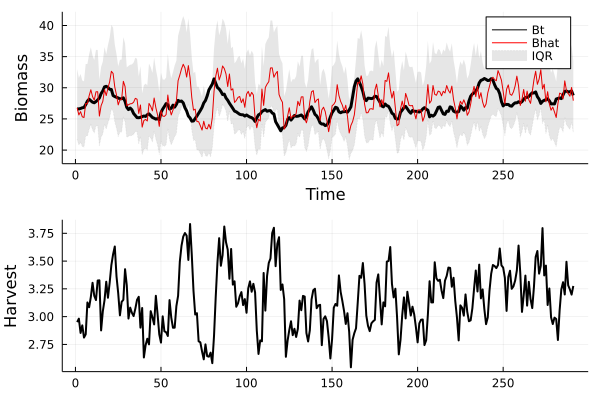

In [1042]:
Ht,Ft,Bt,Bhat,B_lower,B_upper = recovery_series(0.05 ,pars, 0.5, 2.0,1;T = 300, Tshock = 301)
p1 = Plots.plot(exp.(Bt[10:end]), color = "black", width = 3, label = "Bt", ylabel = "Biomass")  
Plots.plot!(exp.(Bhat[10:end]), color = "red", label = "Bhat", xlabel = "Time")
Plots.plot!(exp.(B_lower[10:end]),
fillrange = exp.(B_upper[10:end]),
color = "black", style =:dot, alpha = 0.1, label = "IQR")






p2 = Plots.plot(Ht[10:end], color = "black", width = 2, ylabel = "Harvest", label ="")
#Plots.plot!((Bhat[(Tshock-25):(Tshock+50)] .-Bt[(Tshock-25):(Tshock+50)]).^2)
plot(p1,p2,layout = (2,1))